# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 05.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

Стандартные библиотеки, включая SVM для дальнейшей работы

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.svm import SVC

Воспользуемся примером, представленным непосредственно в документации к sklearn.datasets.

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X_1, y_1 = make_blobs(n_samples=700, centers=2, n_features=2, cluster_std = 0.5, random_state=0)

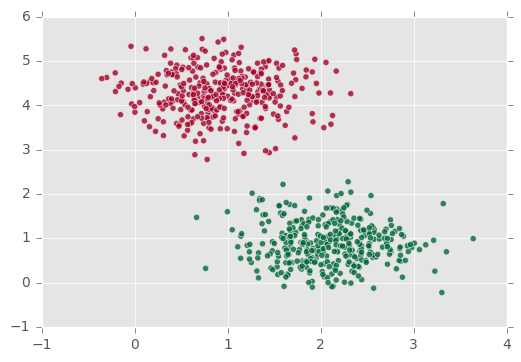

In [3]:
plt.scatter(X_1[:, 0], X_1[:, 1], c = y_1, alpha = 0.8, cmap=plt.cm.RdYlGn)

In [4]:
X_2, y_2 = datasets.make_circles(n_samples=700, shuffle=True, noise=0.05, factor=0.4)

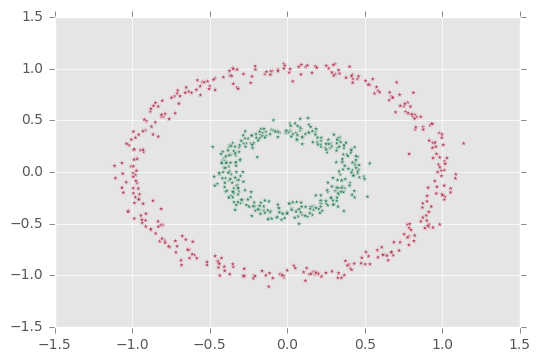

In [5]:
plt.scatter(X_2[:, 0], X_2[:, 1], c = y_2, marker = '*', alpha = 0.7, cmap=plt.cm.RdYlGn)

In [6]:
X_3, y_3 = make_blobs(n_samples=700, centers=2, n_features=2, cluster_std = 5, random_state=0)

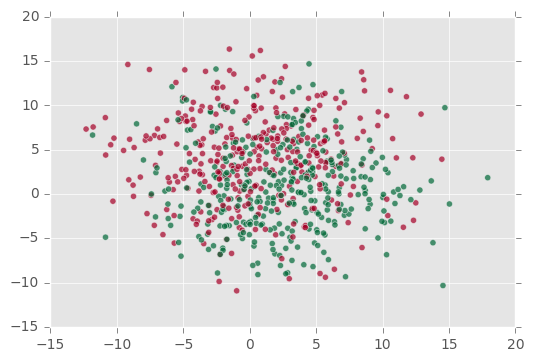

In [7]:
plt.scatter(X_3[:, 0], X_3[:, 1], c = y_3, marker = 'o', alpha = 0.7, cmap=plt.cm.RdYlGn)

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

#### Для начала обучим каждую из выборок на линейном ядре

Воспользуемся кодом из https://github.com/scikit-learn/scikit-learn/pull/8279/files/3c95b551dfbd7604b5c5e03876a34711297aebe1
Здесь как раз строится разделяющая поверхность и полосы.

### LINEAR KERNEL

#### DATASET_1

In [8]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [9]:
models = (SVC(kernel='linear', C = 0.05),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 20),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_1, y_1) for clf in models)

X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

Здесь также воспользуемся различными "финтами" из прошлой ссылки :)

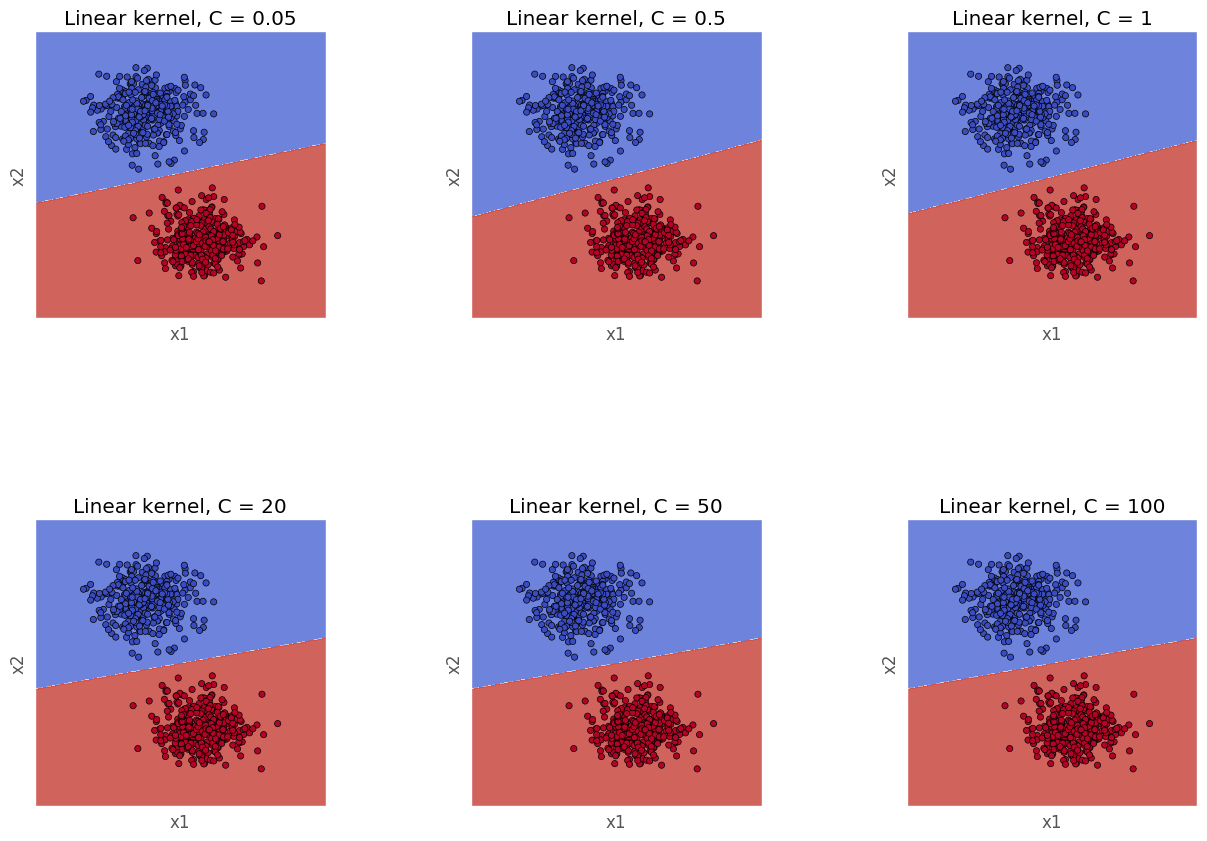

In [12]:
# plotting adjust
fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

# plotting titles
titles = ('Linear kernel, C = 0.05',
          'Linear kernel, C = 0.5',
          'Linear kernel, C = 1',
          'Linear kernel, C = 20', 
          'Linear kernel, C = 50',
          'Linear kernel, C = 100')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
plt.show()

#### DATASET_2

In [18]:
models = (SVC(kernel='linear', C = 0.05),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 20),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_2, y_2) for clf in models)

X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

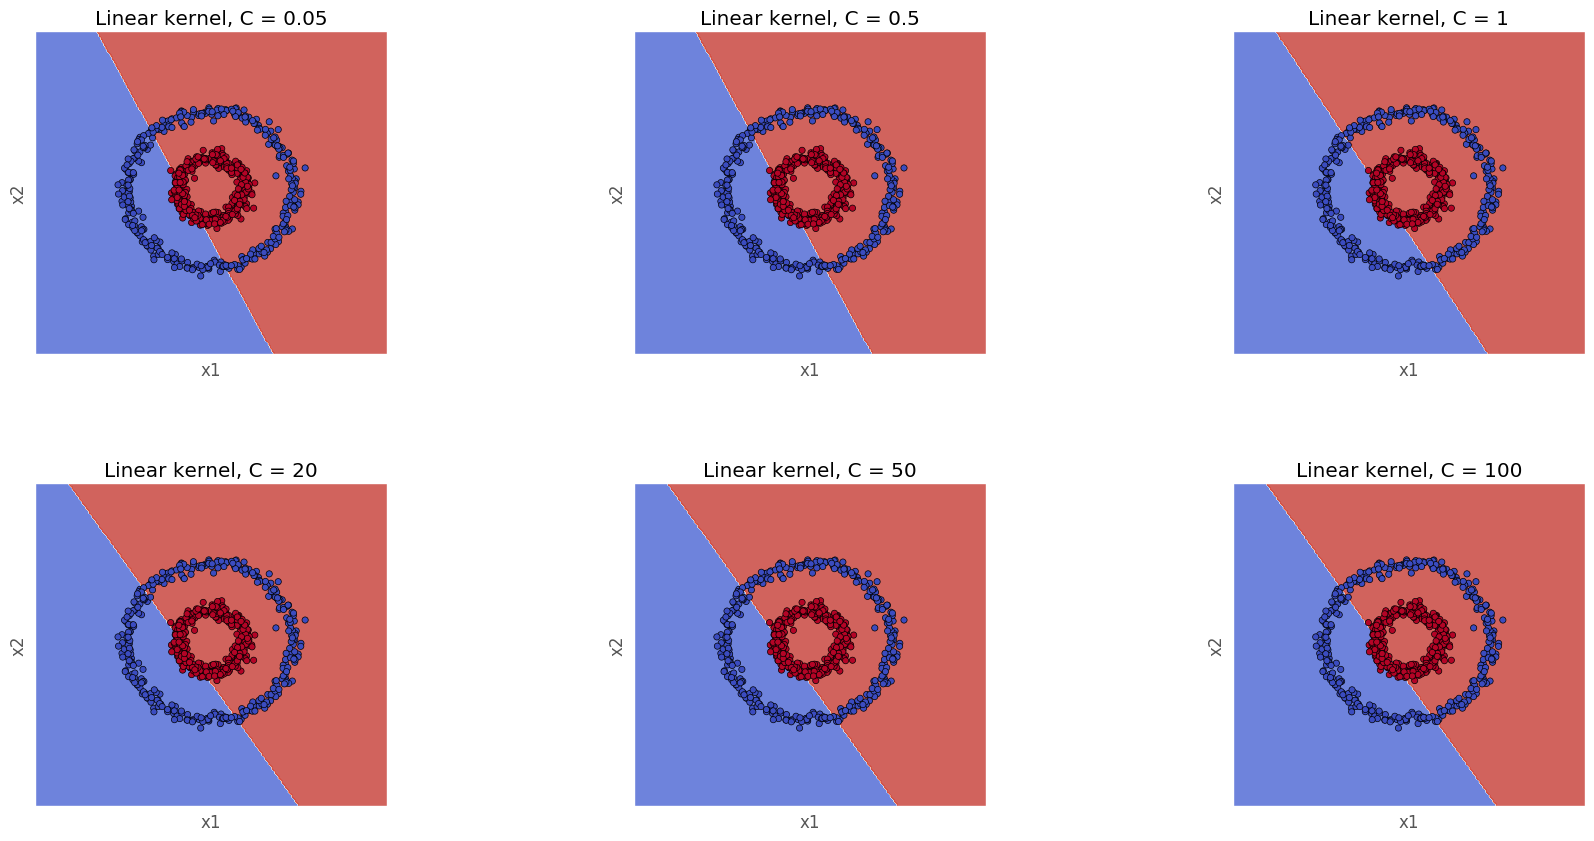

In [19]:
# plotting adjust
fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Linear kernel, C = 0.05',
          'Linear kernel, C = 0.5',
          'Linear kernel, C = 1',
          'Linear kernel, C = 20', 
          'Linear kernel, C = 50',
          'Linear kernel, C = 100')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.show()

#### DATASET_3

In [15]:
models = (SVC(kernel='linear', C = 0.05),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 20),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_3, y_3) for clf in models)

X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

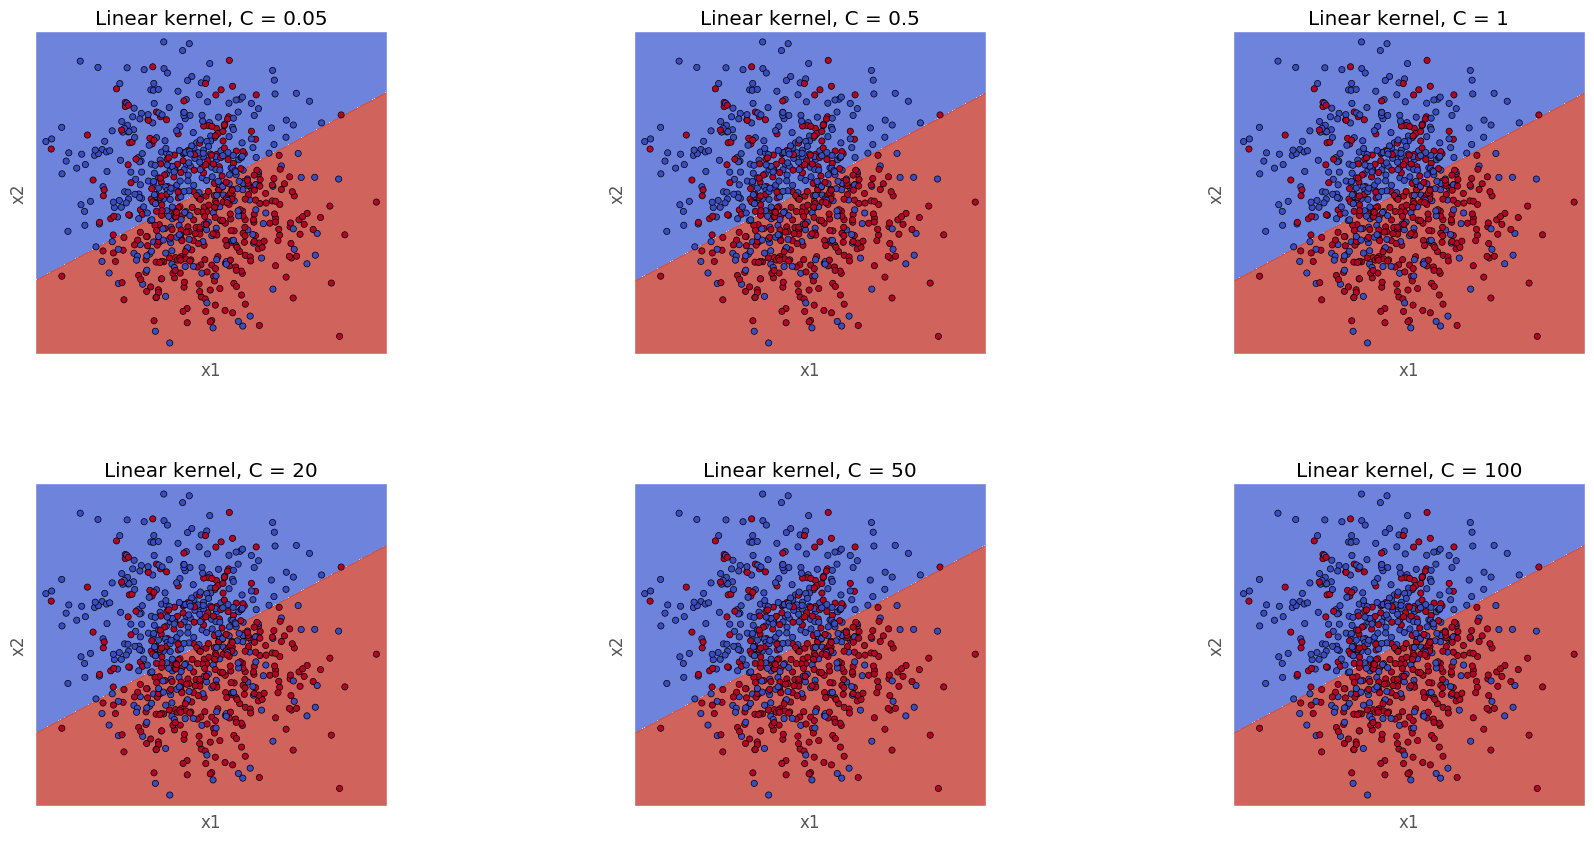

In [16]:
# plotting adjust
fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Linear kernel, C = 0.05',
          'Linear kernel, C = 0.5',
          'Linear kernel, C = 1',
          'Linear kernel, C = 20', 
          'Linear kernel, C = 50',
          'Linear kernel, C = 100')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.show()

### POLYNOMINAL

#### DATASET_1

In [19]:
models = (SVC(kernel='poly', gamma = 0.05, degree = 2, coef0 = 1, C = 0.05),
          SVC(kernel='poly', gamma = 5, degree = 7, coef0 = 1, C = 50),
          SVC(kernel='poly', gamma = 50, degree = 10, coef0 = 1, C = 100))          
models = (clf.fit(X_1, y_1) for clf in models)

X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

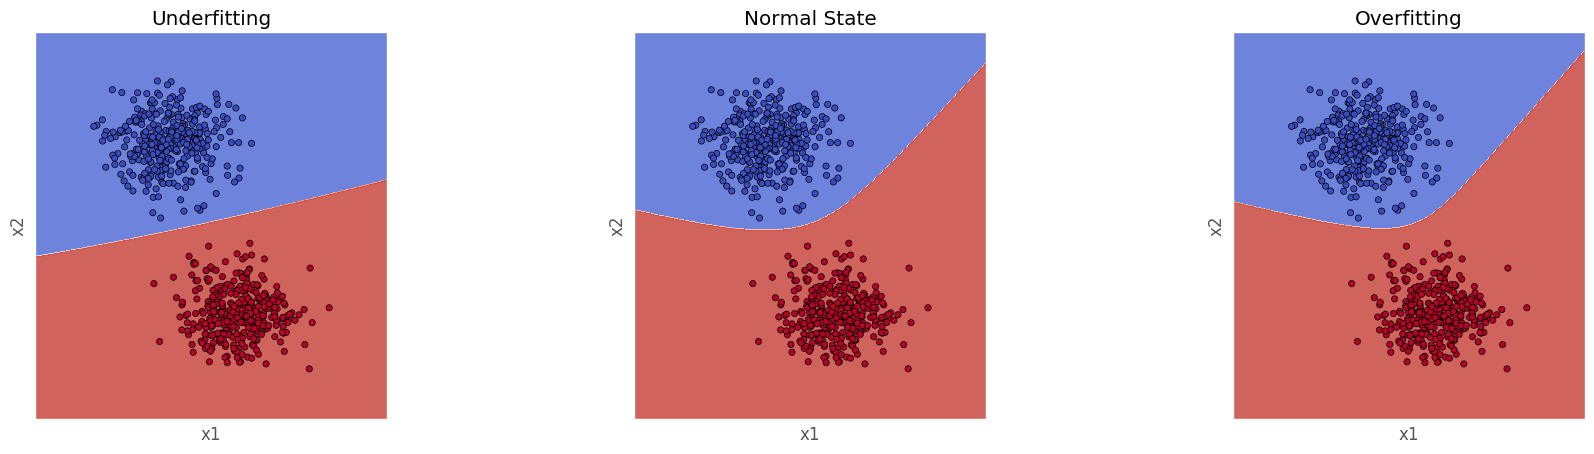

In [20]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

#### DATASET_2

In [21]:
models = (SVC(kernel='poly', gamma = 0.05, degree = 2, coef0 = 1, C = 0.05),
          SVC(kernel='poly', gamma = 5, degree = 7, coef0 = 1, C = 50),
          SVC(kernel='poly', gamma = 50, degree = 10, coef0 = 1, C = 100))          
models = (clf.fit(X_2, y_2) for clf in models)

X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

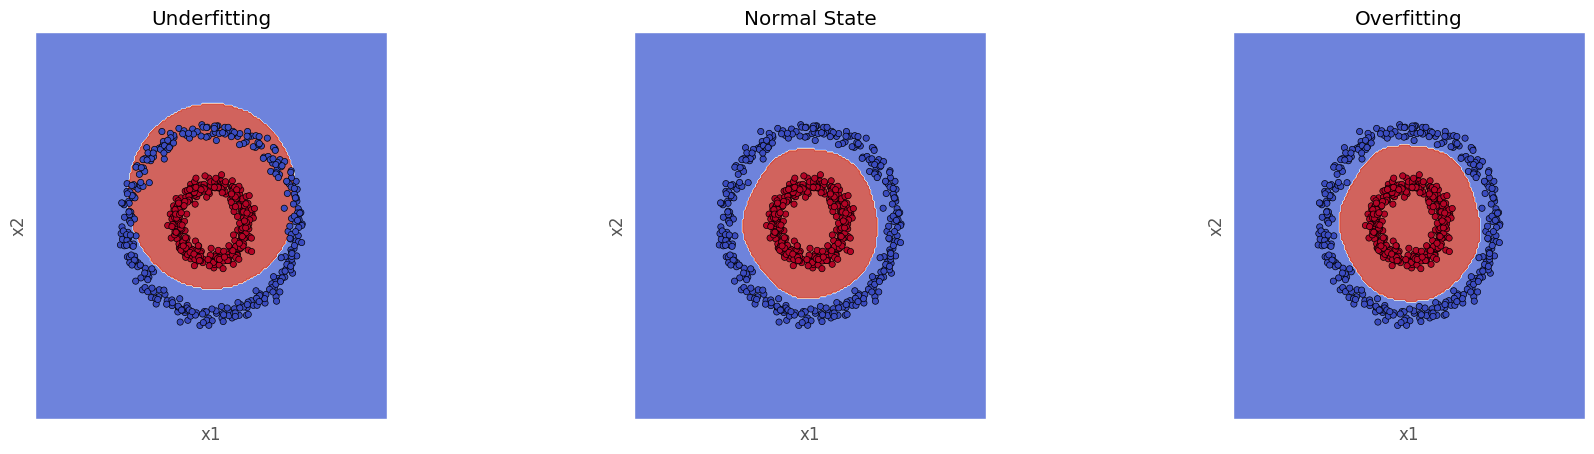

In [22]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

#### DATASET_3

In [14]:
models = (SVC(kernel='poly', gamma = 0.01, degree = 2, coef0 = 1, C = 1),
          SVC(kernel='poly', gamma = 10, degree = 2, coef0 = 1, C = 1),
          SVC(kernel='poly', gamma = 50, degree = 2, coef0 = 1, C = 1))          
models = (clf.fit(X_3, y_3) for clf in models)

X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

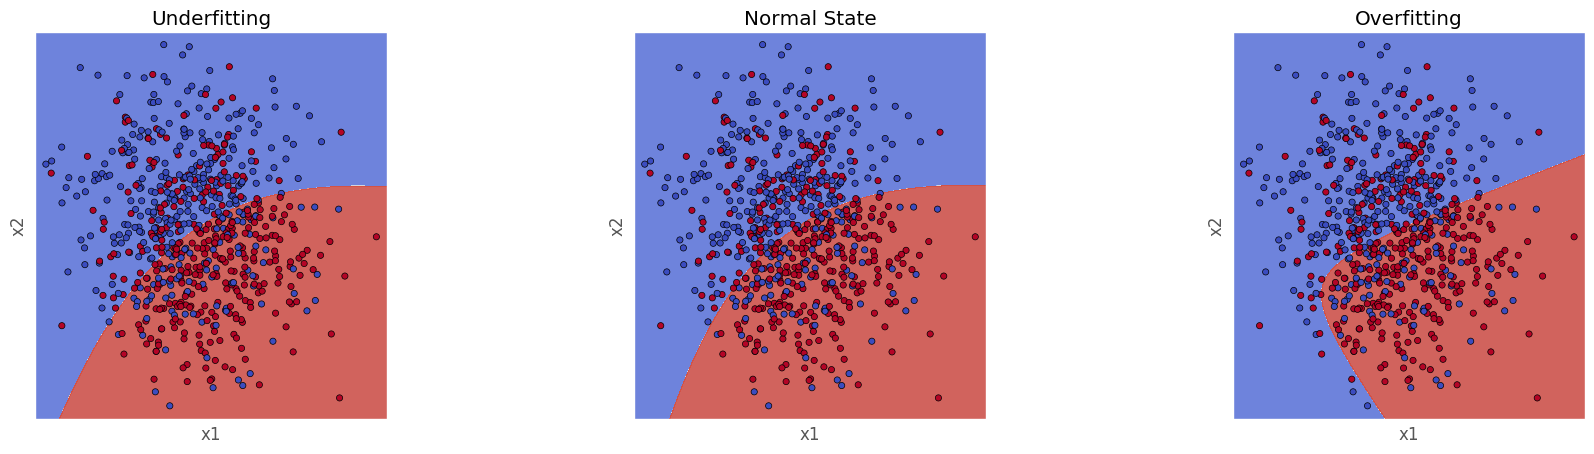

In [15]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

### RBF KERNEL

#### DATASET_1

In [11]:
models = (SVC(kernel='rbf', gamma = 0.000001, C = 1),
          SVC(kernel='rbf', gamma = 0.1, C = 1),
          SVC(kernel='rbf', gamma = 50, C = 1))          
models = (clf.fit(X_1, y_1) for clf in models)

X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

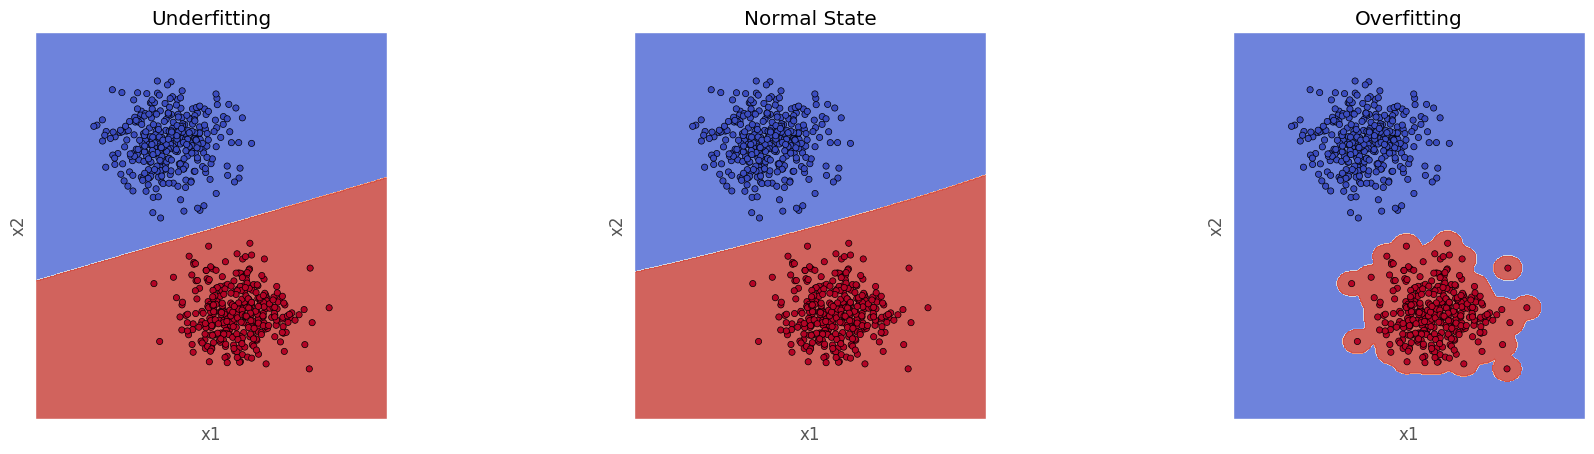

In [12]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

#### DATASET_2

In [13]:
models = (SVC(kernel='rbf', gamma = 0.000001, C = 1),
          SVC(kernel='rbf', gamma = 0.1, C = 1),
          SVC(kernel='rbf', gamma = 50, C = 1))          
models = (clf.fit(X_2, y_2) for clf in models)

X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

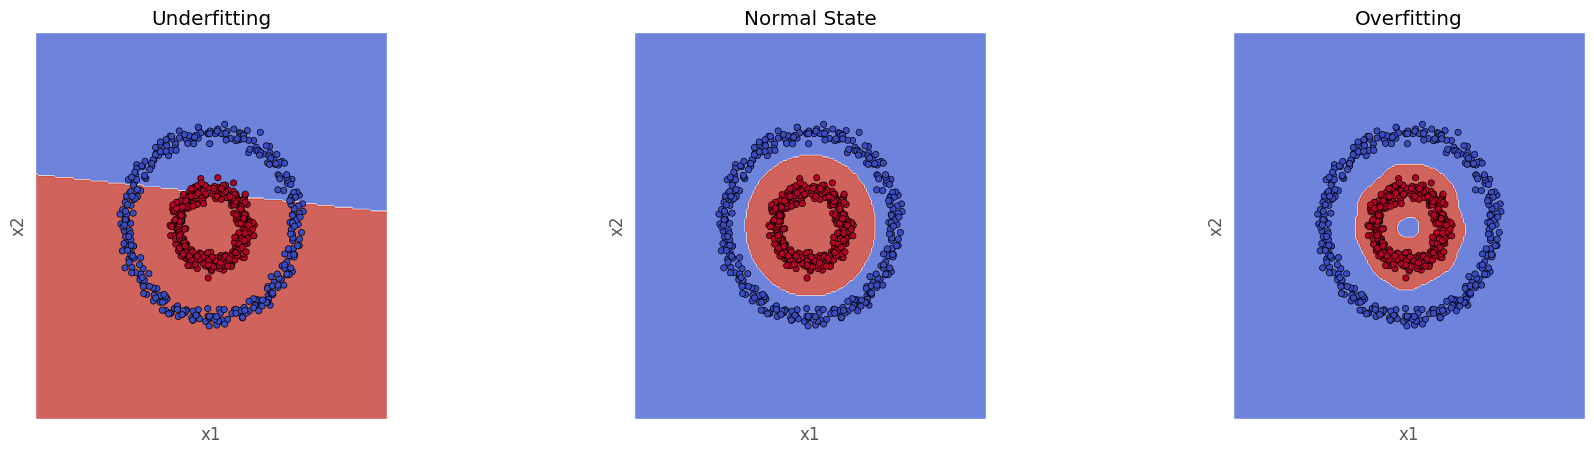

In [14]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

#### DATASET_3

In [15]:
models = (SVC(kernel='rbf', gamma = 0.000001, C = 1),
          SVC(kernel='rbf', gamma = 0.1, C = 1),
          SVC(kernel='rbf', gamma = 50, C = 1))          
models = (clf.fit(X_3, y_3) for clf in models)

X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

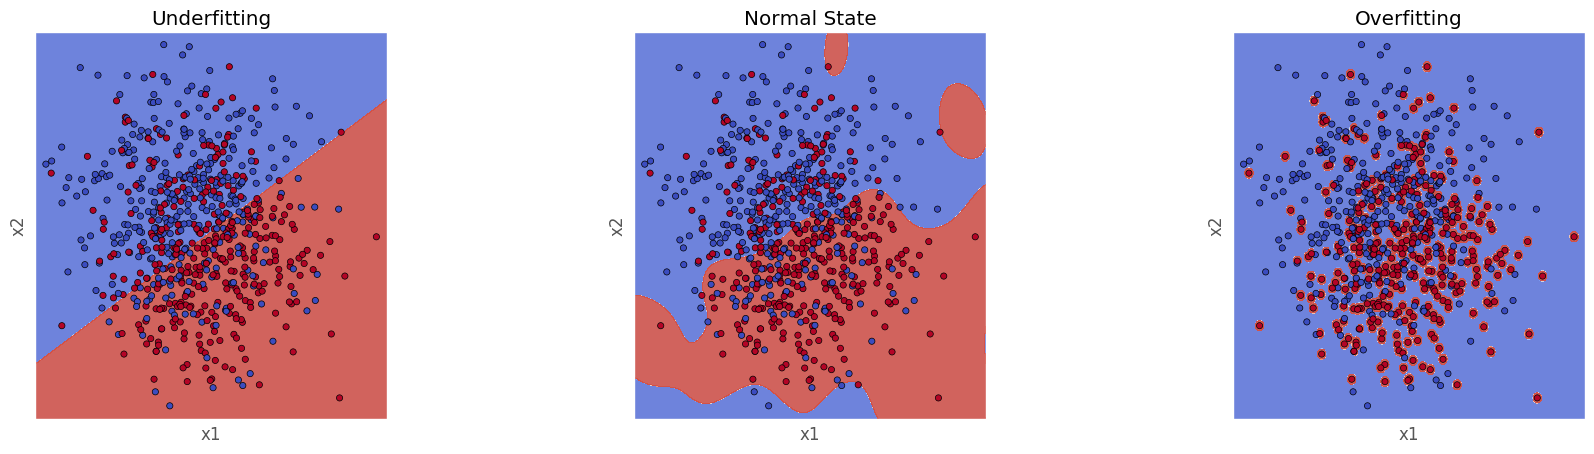

In [16]:
# plotting adjust
fig, sub = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.7, hspace=0.4)

# plotting titles
titles = ('Underfitting',
          'Normal State',
          'Overfitting')

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.show()

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

#### Полиномиальное ядро:

 - Коэффициент "подгонки" $C$, определяющий оптимальную обучаемость наряду с пере- и недообучением. Иными словами, в зависимости от значений (от малого до большого) имеем недо-, нормальное и переобучение

 - Степень ядра $d$ главным образом определеяет новые признаки путем возведения в степень суммы стандартного скалярного произведения и константы $c$, что позволяет более точно и строго отобразить разделяющую гиперплоскость. Таким образом, большое значение $d$ позволяет определить однозначно необходимую нам гиперплоскость. Тем не менее, в задании используется 2 степень, ибо степени старше очень ресурсоемки для посчетов :(

 - Гиперпараметр $\gamma$ влияет на положение гиперплоскости относительно классов. Он, так скажем, регулирует симметрию между классами в отношении данной гиперплоскости. Чем выше, тем более четкое разделение классов, однако при слишком больших значениях наблюдается переобучение.

#### Гауссовское ядро:

 - Гиперпараметр $C$, как и в прошлом случае, служит для подстройки под данные, и его значение, опять-таки, влияет на наличие недо-, нормального и переобучения. Недо- и переобучение случаются ввиду слишком низкой подстройки и слишком сильной подстройки под данные соответственно

 - Как видно из последней модели, параметр $\gamma$ также является фактором подстраивания, но тут это наиболее явно: при одинаковых $C$ и увеличении этого показателя мы имеем налицо переобучение, когда каждый из классов начинает обводиться в качестве отдельной гиперплоскости 

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

Подгрузим необходимые для кросс-валидации библиотеки

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
df = pd.read_csv('train.csv')

In [25]:
df.head()

Activity        D1        D2    D3   D4        D5        D6        D7  \
0         1  0.000000  0.497009  0.10  0.0  0.132956  0.678031  0.273166   
1         1  0.366667  0.606291  0.05  0.0  0.111209  0.803455  0.106105   
2         1  0.033300  0.480124  0.00  0.0  0.209791  0.610350  0.356453   
3         1  0.000000  0.538825  0.00  0.5  0.196344  0.724230  0.235606   
4         0  0.100000  0.517794  0.00  0.0  0.494734  0.781422  0.154361   

         D8        D9  ...    D1767  D1768  D1769  D1770  D1771  D1772  D1773  \
0  0.585445  0.743663  ...        0      0      0      0      0      0      0   
1  0.411754  0.836582  ...        1      1      1      1      0      1      0   
2  0.517720  0.679051  ...        0      0      0      0      0      0      0   
3  0.288764  0.805110  ...        0      0      0      0      0      0      0   
4  0.303809  0.812646  ...        0      0      0      0      0      0      0   

   D1774  D1775  D1776  
0      0      0      0  
1      0      1      0  
2      0      0      0  
3      0      0      0  
4      0      0      0  

[5 rows x 1777 columns]

Предсказываем "Activity". Разделим выборку в пропорции 50/50 на тестовую и обучающие выборки.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size = 0.5, random_state = 12)

##### Линейное ядро

In [39]:
model_lin = SVC(kernel='linear', C = 1)
model_lin.fit(X_train, y_train)
predict_1 = model_lin.predict(X_test)
accuracy_score(predict_1, y_test)

0.72761194029850751

##### Полиномиальное ядро

In [40]:
accuracy_poly = []
gamma = [0.01, 1, 20]
d_param = [1, 2]
for i in d_param:
    for j in gamma:
        model_poly = SVC(kernel='poly', gamma = j, degree = i, coef0 = 1, C = 1)
        model_poly.fit(X_train, y_train)
        predict_2 = model_poly.predict(X_test)
        accuracy_poly.append(accuracy_score(predict_2, y_test))

In [45]:
print(max(accuracy_poly))

0.768656716418


##### Гауссовское ядро

In [44]:
accuracy_rbf = []
gamma = [0.01, 1, 20]
for i in gamma:
    model_rbf = SVC(kernel='rbf', gamma = i, C = 1)
    model_rbf.fit(X_train, y_train)
    predict_3 = model_rbf.predict(X_test)
    accuracy_rbf.append(accuracy_score(predict_3, y_test))

In [46]:
print(max(accuracy_rbf))

0.78091684435


Итак, подбором гиперпараметров в моделях с разными ядрами мы добились точности равной 0.78! Достигнута данная точность благодаря модели с Гауссовским ядром.
Посему, мы можем сказать, что использование ядер однозначно МОЖЕТ (но далеко не обязано!) увеличить качество модели :)

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [47]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

Посмотрим на нее:

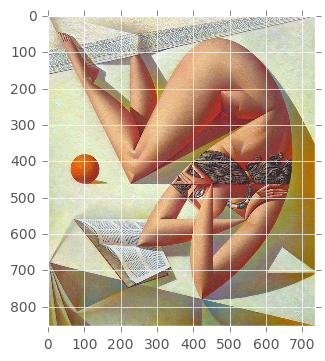

In [48]:
plt.imshow(img);

Для удобства оставим только один канал.

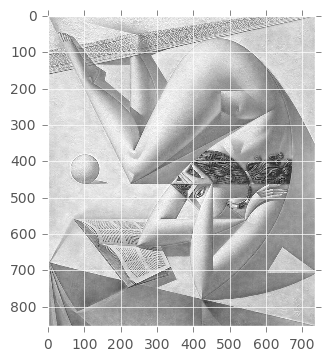

In [49]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

Воспользуемся встроенным в numpy сингулярным разложением

In [50]:
from numpy.linalg import svd

In [53]:
U, s, V = svd(img)

Чтобы получить главные компоненты будем в лоб пользоваться формулой, данной в задании. Но для начала найдем матрицу s, состоящую из сингулярных чисел и нулей.

In [84]:
S = np.zeros((len(U), len(V)))
S[:len(V), :len(V)] = np.diag(s)

In [87]:
S

array([[ 143577.44403243,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,   14159.91615553,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,    9356.80536022, ...,
              0.        ,       0.        ,       0.        ],
       ..., 
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])

Все работает!
Вперед умножать вектора!
Напишем функцию, реализующую визуализацию главных компонент

In [93]:
def pca_img(U, s, V, n):
    A = np.dot(np.dot(U[:, n-1].reshape(-1, 1), s[n-1][n-1]), V[n-1, :].reshape(1, -1))
    plt.imshow(A, cmap='gray')

##### Первые компоненты

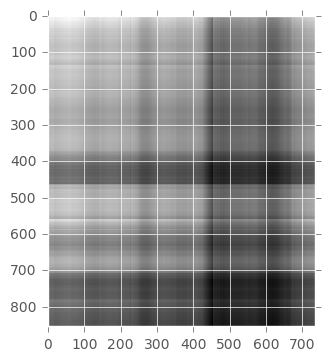

In [95]:
pca_img(U, S, V, 1)

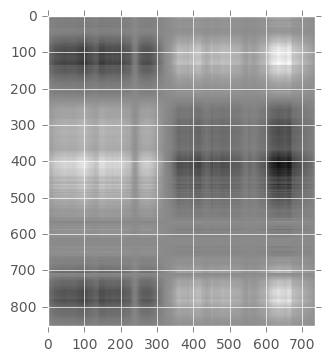

In [96]:
pca_img(U, S, V, 2)

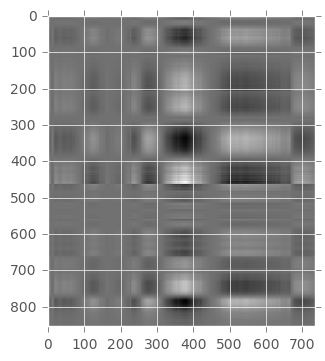

In [97]:
pca_img(U, S, V, 3)

##### Последние компоненты

In [119]:
len(U)-len(V)

117

In [120]:
def pca_img_last(U, s, V, n):
    A = np.dot(np.dot(U[:, -(n+117)].reshape(-1, 1), s[-(n+117)][-n]), V[-n, :].reshape(1, -1))
    plt.imshow(A, cmap='gray')

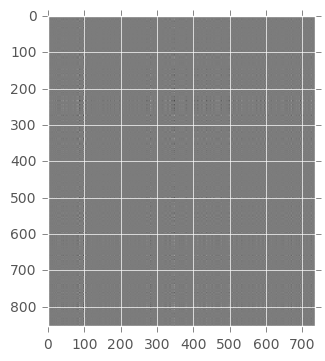

In [121]:
pca_img_last(U, S, V, 1)pca_img_last(U, S, V, 1)

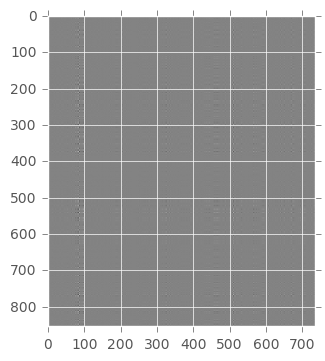

In [122]:
pca_img_last(U, S, V, 2)

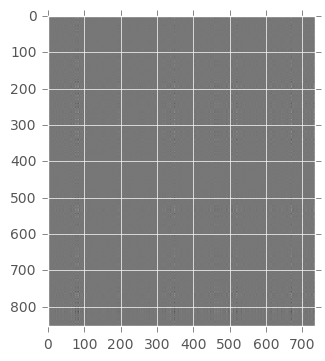

In [123]:
pca_img_last(U, S, V, 3)

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [157]:
var_ratio = []
a = 0
for i in range(len(s)):
    var_ratio.append((s[i]+a)/sum(s))
    a += s[i]

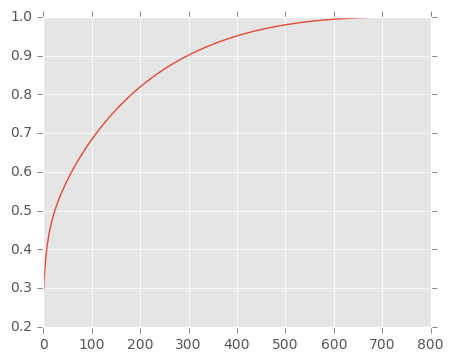

In [158]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(1, len(s)+1), var_ratio)

In [147]:
def pca_img_adj(U, s, V, n):
    A = np.dot(U[:, :n], np.dot(s[:n, :n], V[:n, :]))
    plt.imshow(A, cmap='gray')

Поскольку на графике видно, что порог объясненной дисперсии в 50% преодолевается где-то в 25-40 компонентах, то попробуем взглянуть на получившуюся картинку при данных значениях $n$

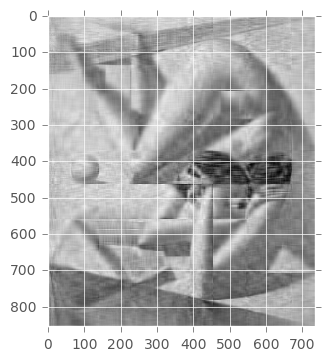

In [159]:
pca_img_adj(U, S, V, 25)

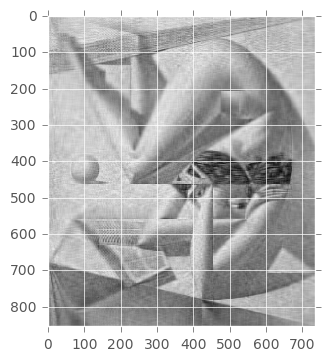

In [161]:
pca_img_adj(U, S, V, 40)

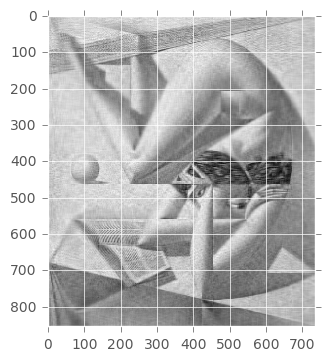

In [162]:
pca_img_adj(U, S, V, 50)

Пожалуй, наиболее оптимальным будет 40 компонент, поскольку при них изображение уже достаточно похоже на изначальное, а при тех же 50 качество хоть и выше, но совсем немного, что не релевантно в таком случае.

##### Вес изображения

In [ ]:
img1 = np.dot(U[:, :40], np.dot(S[:40, :40], V[:40, :]))

In [179]:
size0 = sys.getsizeof(img)
size1 = sys.getsizeof(img1)
print(size0, size1)

112 5022576


Итак, как мы видим, объемы несоизмеримы...в чем дело?Скорее всего, дело в формате объектов, а также в том, как команда sys.getsizeof() воспринимает каждый из объектов. Попробуем решить данную проблему, приводя каждое из изображение к эррэю.

In [184]:
import scipy

In [187]:
img2 = scipy.misc.imread('art.jpg')

In [188]:
size0 = sys.getsizeof(np.array(img2, dtype = 'float32'))
size1 = sys.getsizeof(np.array(img1, dtype = 'float32'))
print(size0, size1)

7533824 2511344


In [192]:
answer = size0/size1
print('Вес изображения при использовании 40 главных компонент упадет примерно в', round(answer), 'раза')

Вес изображения при использовании 40 главных компонент упадет примерно в 3 раза


## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

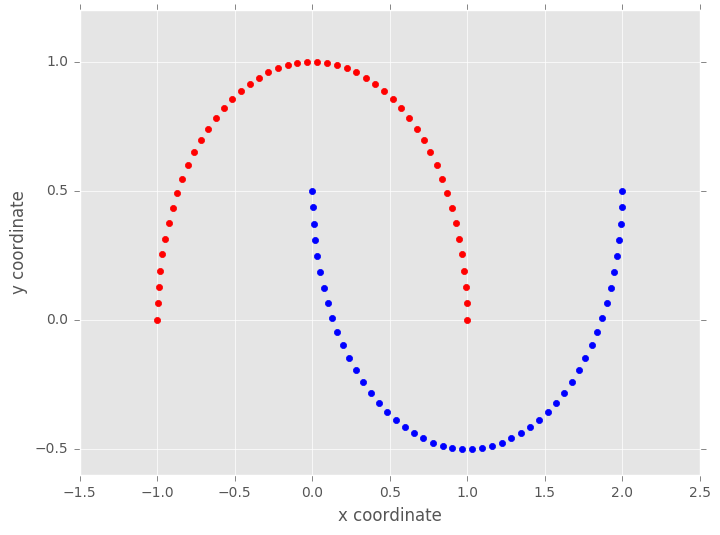

In [196]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [197]:
from sklearn.decomposition import PCA
# Your code here

##### Одна компонента

In [198]:
pca_1 = PCA(n_components = 1)
pca_1.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [199]:
X_pca = pca_1.transform(X)

Воспользуемся примером, представленным в документации http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

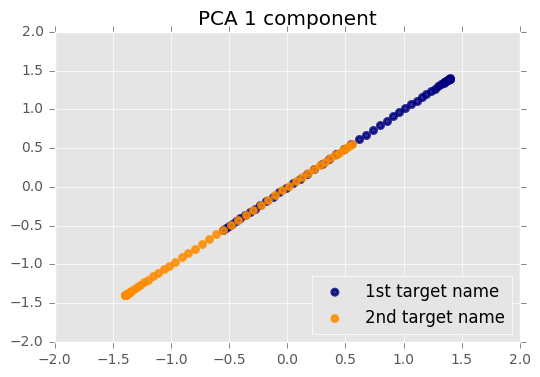

In [219]:
colors = ['navy', 'darkorange']
lw = 2
target_names = ['1st target name','2nd target name']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i], X_pca[y == i], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='lower right', shadow=False, scatterpoints=1)
plt.title('PCA 1 component')

Для одной компоненты хоть и выглядит верно, но в целом непрезентабельно :(
Сделаем bin'ы!

In [218]:
X_pca_bins = [X_pca[y == 0], X_pca[y == 1]]

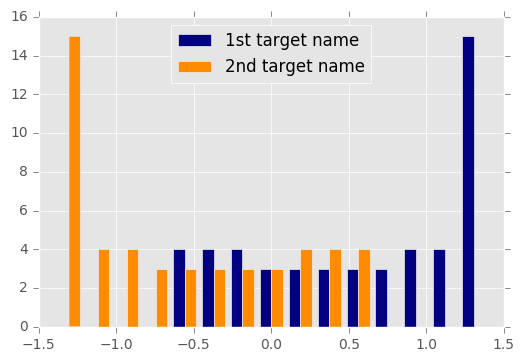

In [224]:
plt.hist(X_pca_bins, 15, color = colors, label=target_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

##### Две компоненты

In [208]:
pca_2 = PCA(n_components = 2)
pca_2.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [209]:
X_pca2 = pca_2.transform(X)

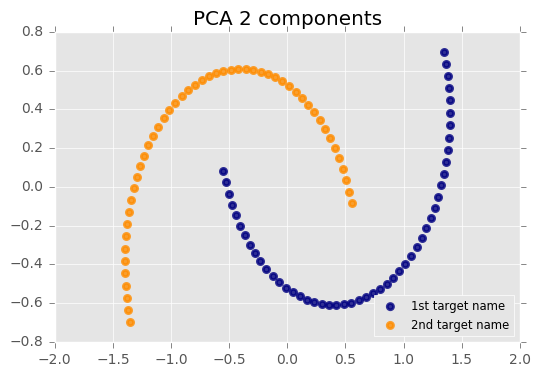

In [226]:
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca2[y == i, 0], X_pca2[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='lower right', shadow=False, scatterpoints=1, fontsize = 'small')
plt.title('PCA 2 components')

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [194]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [195]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma * mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1, n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

##### Одна компонента

gamma = 0.1

In [232]:
X_rbf1_1 = stepwise_kpca(X, 0.1, 1)

In [233]:
X_rbf1_1 = [X_rbf1_1[y == 0], X_rbf1_1[y == 1]]

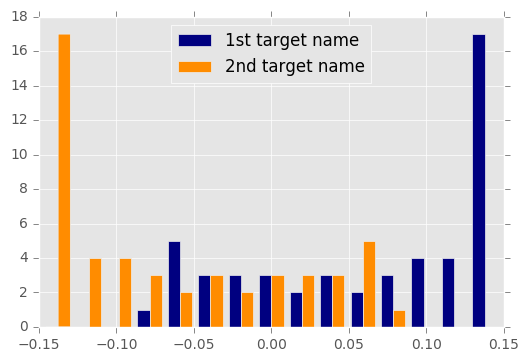

In [234]:
plt.hist(X_rbf1_1, 15, color = colors, label=target_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

gamma = 20

In [235]:
X_rbf1_2 = stepwise_kpca(X, 20, 1)

In [236]:
X_rbf1_2 = [X_rbf1_2[y == 0], X_rbf1_2[y == 1]]

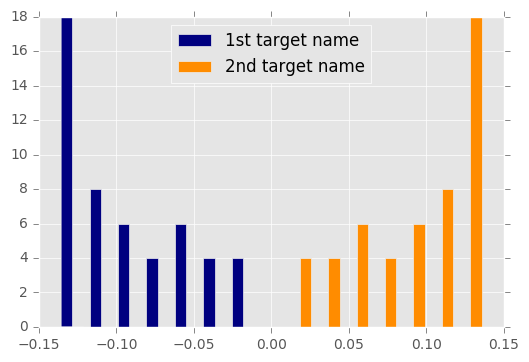

In [237]:
plt.hist(X_rbf1_2, 15, color = colors, label=target_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

Как мы видим, при значении $gamma$ равного 20 выборки становятся линейно разделимыми для одной главной компоненты.

##### Две компоненты

gamma = 0.1

In [238]:
X_rbf2_1 = stepwise_kpca(X, 0.1, 2)

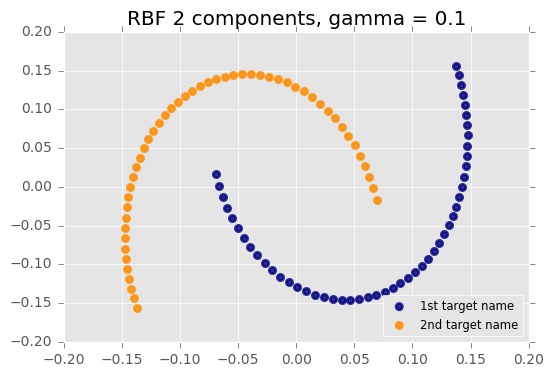

In [242]:
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_rbf2_1[y == i, 0], X_rbf2_1[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='lower right', shadow=False, scatterpoints=1, fontsize = 'small')
plt.title('RBF 2 components, gamma = 0.1')

gamma = 15

In [248]:
X_rbf2_2 = stepwise_kpca(X, 15, 2)

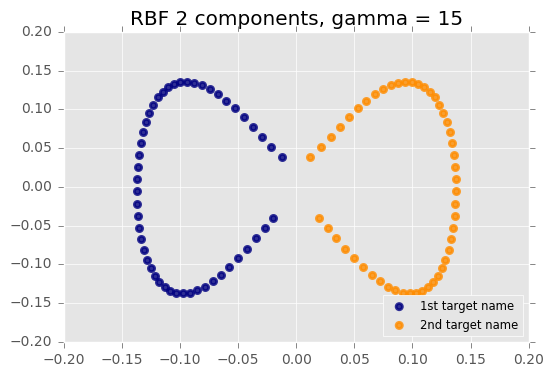

In [249]:
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_rbf2_2[y == i, 0], X_rbf2_2[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='lower right', shadow=False, scatterpoints=1, fontsize = 'small')
plt.title('RBF 2 components, gamma = 15')

Здесь также видно, что четкое разделение на классы достигается при минимальном значении параметра $gamma$ равном 15

### Ваши мысли о задании:

В целом задание интересное...как всегда в принципе, но основное замечание у меня к сложности. Да, оно, что называется, "делабельное", но что делать ребятам, скажем, которые первый год в Питоне?..жалко их :(
Стоит, наверно, давать сложные и попроще домашки, хотя это будет не совсем справедливо...
В общем, есть к чему стремиться!

### Здесь можете поделиться картинкой

<img src="https://style.news.am/static/news/b/2014/11/17665.jpg">